In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/iris/config.py:139: UserWarning: Ignoring config item 'Resources':'test_data_dir' (section:option) as '/home/h05/itwl/projects/git/iris-test-data/test_data' is not a valid directory path.
  warnings.warn(msg.format(section, option, c_path))


### Prepare data

In [2]:
# List of dataset to use for training
train_files = ["ssp126", "ssp585", "historical", "hist-GHG"]

In [3]:
# Create training and testing arrays
X_train = pd.concat([create_predictor_data(file) for file in train_files])
y_train_pr90 = np.vstack([create_predictdand_data(file)['pr90'].values.reshape(-1, 96 * 144)
                         for file in train_files])

X_test = create_predictor_data('ssp245')
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
pr90_truth = 86400 * Y_test["pr90"].mean('member')

In [4]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_pr90 = y_train_pr90[~nan_train_mask]
assert len(X_train) == len(y_train_pr90)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
pr90_truth = pr90_truth[~nan_test_mask]

In [5]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [6]:
# Standardize predictand fields
train_pr90_mean, train_pr90_std = y_train_pr90.mean(), y_train_pr90.std()
y_train_pr90 = (y_train_pr90 - train_pr90_mean) / train_pr90_std

### Prepare model

In [7]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

In [8]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_pr90.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [9]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

      fun: 8783936.317596287
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.98695083e+00,  7.08107087e+00, -9.75972885e+00, -2.32831628e+01,
        2.57462640e-02,  1.49273815e+00,  5.47636932e-02,  3.15923307e+00,
        7.12697473e-01,  1.22013231e+01, -1.05016791e+01, -1.85508542e+01,
       -1.14010326e+00,  1.96789172e+01,  1.34081355e+01,  1.15679414e+01,
        1.94205336e+02,  4.53549232e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 233
      nit: 199
   status: 0
  success: True
        x: array([ 4.10880644, -0.49325987,  1.06977275, -4.19366708,  0.48272066,
       -2.72993017, -0.15899717, -6.42529993, -3.34429664, -3.78589404,
       -0.28444987, -3.2281845 ,  6.64794547, -2.56133182, -1.95714517,
        0.84197492, -0.5415694 ,  0.06554527])

### Predict on testing set

In [10]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_pr90_std + train_pr90_mean
posterior_std = np.sqrt(standard_posterior_var) * train_pr90_std

In [11]:
# put output back into xarray format for calculating RMSE/plotting
posterior_pr90 = np.reshape(posterior_mean, [86, 96, 144])
posterior_pr90_std = np.reshape(posterior_std, [86, 96, 144])
posterior_pr90_data = xr.DataArray(posterior_pr90, dims=pr90_truth.dims, coords=pr90_truth.coords)
posterior_pr90_std_data = xr.DataArray(posterior_pr90_std, dims=pr90_truth.dims, coords=pr90_truth.coords)

In [13]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(pr90_truth[35], posterior_pr90_data[35])}")
print(f"RMSE at 2100: {get_rmse(pr90_truth[85], posterior_pr90_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(pr90_truth[30:41], posterior_pr90_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr90_truth[75:], posterior_pr90_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr90_truth[35:], posterior_pr90_data[35:]).mean()}")

RMSE at 2050: 1.2770842482697986
RMSE at 2100: 1.5993201834625697
RMSE 2045-2055: 1.4856863650886318
RMSE 2090-2100: 1.518483843325241
RMSE 2050-2100: 1.5399658738205562


[Text(0.5, 1.0, 'Difference')]

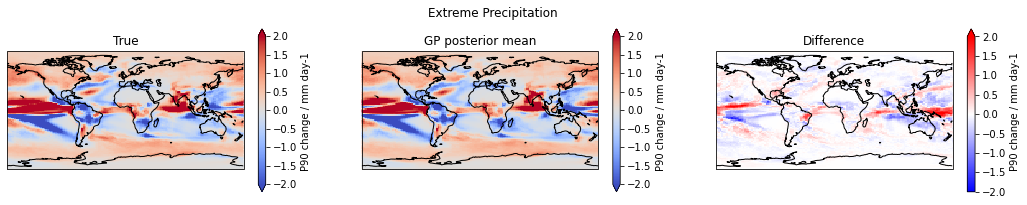

In [14]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Extreme Precipitation')

# Test
plt.subplot(131, projection=proj)
pr90_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-2,
                              cbar_kwargs={"label":"P90 change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_pr90_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-2,
                              cbar_kwargs={"label":"P90 change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr90_truth - posterior_pr90_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"P90 change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- CO2 (0.48)
- SO2 (1.20)
- Significant internal variability (0.46)

In [15]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.06554527]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.47662699647917733
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,4.1251003363482415
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.01497810987036654
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.3647430516955077
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.02243501176060747
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.96335643, 0.06318496, 0.61680528..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,1.2002497222664752
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.5610023, 0.03886428, 6.64924131..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.45858618765265946


In [16]:
# Save predictions
posterior_pr90_data.to_netcdf('climatebench-gp-posterior-mean-pr90-test-2019-2100.nc')
posterior_pr90_std_data.to_netcdf('climatebench-gp-posterior-std-pr90-test-2019-2100.nc')